# F1 Analysis - Introduction to Data Sciences project

### Importing libraries

In [1]:
# Already added some that we most probably will use
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# Add more whenever needed
# ...
from datetime import datetime
from math import floor
from matplotlib.ticker import MultipleLocator

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

### Reading in the data

The data consists of most of the freely available Formula 1 data from 1950 to 2018. <br>
Link: http://ergast.com/mrd/

In [2]:
circuits = pd.read_csv('./f1db_csv/circuits.csv', header=None)
constructor_results = pd.read_csv('./f1db_csv/constructor_results.csv', header=None)
constructor_standings = pd.read_csv('./f1db_csv/constructor_standings.csv', header=None)
constructors = pd.read_csv('./f1db_csv/constructors.csv', header=None)
drivers = pd.read_csv('./f1db_csv/driver.csv', header=None)
driver_standings = pd.read_csv('./f1db_csv/driver_standings.csv', header=None)
lap_times = pd.read_csv('./f1db_csv/lap_times.csv', header=None)
pit_stops = pd.read_csv('./f1db_csv/pit_stops.csv', header=None)
qualifying = pd.read_csv('./f1db_csv/qualifying.csv', header=None)
races = pd.read_csv('./f1db_csv/races.csv', header=None)
results = pd.read_csv('./f1db_csv/results.csv', header=None)
seasons = pd.read_csv('./f1db_csv/seasons.csv', header=None)
status = pd.read_csv('./f1db_csv/status.csv', header=None)

### Adding correct column names to the datasets

Column names are based on the column names from here: https://www.kaggle.com/cjgdev/formula-1-race-data-19502017. <br>
Column names in our project are in snake case (snake_case).

In [3]:
circuits_column_names = ['circuit_id', 'circuit_ref', 'name', 'location', 'country', 'lat', 'lng', 'alt', 'url']
constructor_results_column_names = ['constructor_results_id', 'race_id', 'constructor_id', 'points', 'status']
constructor_standings_column_names = ['constructor_standings_id', 'race_id', 'constructor_id', 'points', 'position', 'position_text', 'wins']
constructors_column_names = ['constructor_id', 'constructor_ref', 'name', 'nationality', 'url']
drivers_column_names = ['driver_id', 'driver_ref', 'number', 'code', 'forename', 'surname', 'birth_date', 'nationality', 'url']
driver_standings_column_names = ['driver_standings_id', 'race_id', 'driver_id', 'points', 'position', 'position_text', 'wins']
lap_times_column_names = ['race_id', 'driver_id', 'lap', 'position', 'time', 'milliseconds']
pit_stops_column_names = ['race_id', 'driver_id', 'stop', 'lap', 'time', 'duration', 'milliseconds']
qualifying_column_names = ['qualify_id', 'race_id', 'driver_id', 'constructor_id', 'number', 'position', 'q1', 'q2', 'q3']
races_column_names = ['race_id', 'year', 'round', 'circuit_id', 'name', 'date', 'time', 'url']
results_column_names = ['result_id', 'race_id', 'driver_id', 'constructor_id', 'number', 'grid', 'position', 'position_text', 'position_order', 'points', 'laps', 'time', 'milliseconds', 'fastest_lap', 'rank', 'fastest_lap_time', 'fastest_lap_speed', 'status_id']
seasons_column_names = ['year', 'url']
status_column_names = ['status_id', 'status']

In [4]:
circuits.columns = circuits_column_names
constructor_results.columns = constructor_results_column_names
constructor_standings.columns = constructor_standings_column_names
constructors.columns = constructors_column_names
drivers.columns = drivers_column_names
driver_standings.columns = driver_standings_column_names
lap_times.columns = lap_times_column_names
pit_stops.columns = pit_stops_column_names
qualifying.columns = qualifying_column_names
races.columns = races_column_names
results.columns = results_column_names
seasons.columns = seasons_column_names
status.columns = status_column_names

### Replacing different types of non-existent (and non-sensical) values with a universal one

We are using np.nan as the universal non-existent value.

In [5]:
datasets = [circuits, constructor_results, constructor_standings, constructors, drivers, driver_standings, lap_times, pit_stops, qualifying, races, results, seasons, status]

for data in datasets:
    for column in data.columns:
        data[column] = data[column].replace('\\N', np.nan)  # Replacing previously used non-existent value with ours
        data[column] = data[column].replace('', np.nan)  # Replacing missing values

### Writing the adjusted DataFrames to .csv files for ease of manual checking and look up

In [6]:
dataset_names = ["circuits", "constructor_results", "constructor_standings", "constructors", "drivers", "driver_standings", "lap_times", "pit_stops", "qualifying", "races", "results", "seasons", "status"]

# DataFrames are in the folder 'f1_datasets_adjusted' as .csv files (with UTF-8 encoding)

# Commented out because there is no reason to keep writing them every time the notebook is ran
#for i in range(len(datasets)):
#    file_name = "f1_datasets_adjusted/" + dataset_names[i] + ".csv"
#    datasets[i].to_csv(file_name, sep=',', encoding='utf-8', index=False)

### Finding the minimum and maximum values of each feature of each dataset

In [7]:
datasets_minimum_values = []
datasets_maximum_values = []

for i in range(len(datasets)):
    print("Name of dataset: " + str(dataset_names[i]))
    print("Minimum values of each feature in the dataset:")
    min_values = datasets[i].min()
    print(min_values)
    datasets_minimum_values.append(min_values)
    print("Maximum values of each feature in the dataset:")
    max_values = datasets[i].max()
    print(max_values)
    datasets_maximum_values.append(max_values)
    print()
    print()

Name of dataset: circuits
Minimum values of each feature in the dataset:
circuit_id                                        1
circuit_ref                                     BAK
name                                        A1-Ring
location                                  Abu Dhabi
country                                   Argentina
lat                                        -37.8497
lng                                        -118.189
url            http://en.wikipedia.org/wiki/A1-Ring
dtype: object
Maximum values of each feature in the dataset:
circuit_id                                      74
circuit_ref                                 zolder
name                                        Zolder
location                                 Zandvoort
country                                    Vietnam
lat                                        57.2653
lng                                        144.968
url            http://en.wikipedia.org/wiki/Zolder
dtype: object


Name of dataset: construct

## Comparing the fastest lap times at frequent circuits during the 2004-2018 period

We are using the absolute fastest lap times at every track year by year (fastest lap during the race). <br>
There are 14 such circuits. <br>
Afterwards we shall make a AxB grid of the corresponding graphs.

<module 'matplotlib.pyplot' from 'C:\\Users\\Siim\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


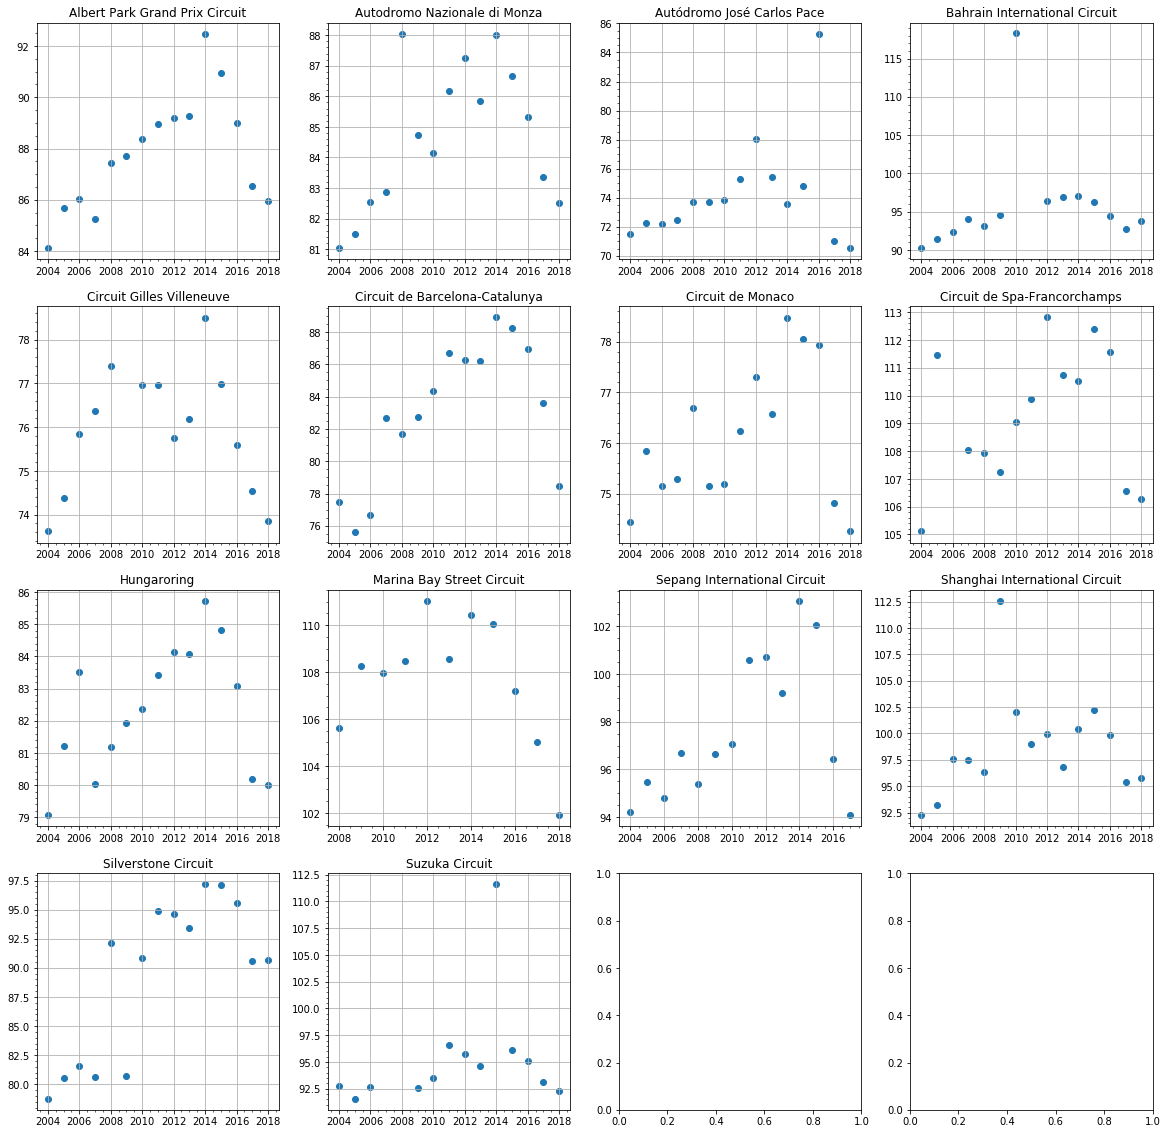

In [8]:
years = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

suitable_races = []

for index, row in races.iterrows():
    year = int(row['year'])
    if (year in years):  # If the year of the race is between 2004 and 2018
        suitable_races.append([row['race_id'], row['circuit_id'], year])

circuit_year_lap = []

for race in suitable_races:
    race_id = race[0]
    race_lap_times = results.loc[results['race_id'] == race_id]['fastest_lap_time']
    lowest_race_lap_time = 10000
    for lap_time in race_lap_times:
        if (not lap_time is np.nan):
            minutes_seconds = lap_time.split(":")
            lap_time = float(int(minutes_seconds[0]) * 60 + float(minutes_seconds[1]))
            if (lap_time < lowest_race_lap_time):
                lowest_race_lap_time = lap_time
    circuit_year_lap.append([race[1], race[2], lowest_race_lap_time])

for i in circuit_year_lap:
    circuit_id = i[0]
    circuit_name = circuits.loc[circuits['circuit_id'] == circuit_id]['name']
    i[0] = circuit_name.tolist()[0]
    
df_circuit_year_lap = pd.DataFrame(circuit_year_lap)
df_circuit_year_lap.columns = ['circuit', 'year', 'fastest lap time (s)']

df_circuit_year_lap = df_circuit_year_lap.sort_values(['circuit', 'year'], ascending=True)
    

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
df_circuit_year_lap = df_circuit_year_lap.groupby('circuit').filter(lambda x : len(x)>10)

circuits_list = df_circuit_year_lap.circuit.unique()
#fig = plt.figure()
#plt.figure(figsize =(16,30))

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

row = 1
column = 1

for circuit in circuits_list:
    if(column == 5):
        row += 1
        column =1
        
    axes[row-1, column-1].minorticks_on()
    axes[row-1, column-1].scatter(df_circuit_year_lap[df_circuit_year_lap.circuit == circuit].year, df_circuit_year_lap[df_circuit_year_lap.circuit == circuit]['fastest lap time (s)'])
    axes[row-1, column-1].set_title(circuit)
    axes[row-1, column-1].grid(True)

    column += 1
print(plt)

Seaborn plot tests.

## Predicting the race winners of the 2018 season based on pre-race and race data (except for finishing positions) from 2014-2017

2018 is the last season of which we have data. <br>
2014-2018 are the years following regulation (rules) changes after 2013 so the data should be somewhat similiar.

Because the data is from the past we know that only racers from the top 3 teams (Mercedes, Ferrari, Red Bull) have won races during this period, thus we will focus only on the 6 drivers in these teams (each team has 2 drivers in every race).

It's worth noting that all 6 drivers were in those teams for only the 2017 season. Earlier on some of them were in different teams. This means we have to use data from their earlier races for other teams as well.

The top 6 drivers during 2018: <br>
Red Bull
* Max Verstappen
* Daniel Ricciardo

Ferrari
* Sebastian Vettel
* Kimi Räikkönen

Mercedes
* Lewis Hamilton
* Valtteri Bottas

Info to use
* Circuit (id)
* Season
* Constructor (id)
* Pit stops
* Pit stop duration
* Qualifying position (from qualifying dataset)
* Q3 time (if it doesn't exist use the slowest of the rest of the top 6, because they probably had a mechanical issue and thus the time would ruin predictions)
* Grid position (from results dataset) (doesn't have to match qualifying position, i.e. they got penalties for swapping parts after the qualifying)
* On which lap they got the fastest lap (from results dataset)
* Time of the fastest lap (from results dataset)
* Round (which race of the year was it, i.e. the 5th race out of 22) (from races dataset)

We will create a training dataset from years 2014-2016. <br>
The validation dataset will be of the year 2017. <br>
The test dataset will be of the year 2018.

Finding all races which took place between 2014 and 2018.

In [9]:
years = [2014, 2015, 2016, 2017, 2018]
# Max Verstappen, Daniel Ricciardo, Sebastian Vettel, Kimi Räikkönen, Lewis Hamilton, Valtteri Bottas
driver_ids = [830, 817, 20, 8, 1, 822]

suitable_races = []
for index, row in races.iterrows():
    year = int(row['year'])
    if (year in years):  # If the year of the race is between 2014 and 2018
        suitable_races.append([row['race_id'], year, row['circuit_id'], row['round']])
        
#print(suitable_races)

Finding values for: result_id, race_id, driver_id, constructor_id, grid_position, lap_nr_of_fastest_lap, fastest_lap_time.

In [10]:
# Suitable personal results
suitable_results = []
for race in suitable_races:
    race_id = race[0]
    suitable_race_all_results = results.loc[results['race_id'] == race_id]
    for driver_id in driver_ids:
        suitable_race_driver_results = suitable_race_all_results.loc[suitable_race_all_results['driver_id'] == driver_id]
        # The driver did indeed take part in this race
        if (suitable_race_driver_results.empty == False):
            # Converting Series to a list and then taking the first (and only) element from the list (the 'result_id')
            result_id = suitable_race_driver_results['result_id'].tolist()[0]
            constructor_id = suitable_race_driver_results['constructor_id'].tolist()[0]
            grid_position = suitable_race_driver_results['grid'].tolist()[0]
            lap_nr_of_fastest_lap = suitable_race_driver_results['fastest_lap'].tolist()[0]
            fastest_lap_time = suitable_race_driver_results['fastest_lap_time'].tolist()[0]
            result_data_to_append = [result_id, race_id, driver_id, constructor_id, grid_position, 
                              lap_nr_of_fastest_lap, fastest_lap_time]
            suitable_results.append(result_data_to_append)          

# At this point we have the result_id, race_id, driver_id, constructor_id, grid_position, 
# lap_nr_of_fastest_lap, fastest_lap_time

#print(suitable_results)

Finding values for: year, circuit, round, qualifying position, Q3 time, amount of pit stops, pit stop duration.

In [11]:
df_results = pd.DataFrame(suitable_results)
df_results.columns = ['result_id', 'race_id', 'driver_id', 'constructor_id', 'grid_position', 
                      'lap_of_fastest_lap', 'fastest_lap_time']

# Adding the missing columns (with np.nan)
# Using np.nan some int values turn into floats
# This is one fix for some values (but not all):
# (with -1 as the value so if we later add int-s they won't be made into floats)
# This can also be fixed later and for the machine learning this should not matter at all
unadded_columns = ['circuit', 'year', 'pit_stops', 'pit_stop_duration', 'qualifying_position', 'Q3_time', 'round']
for column in unadded_columns:
    df_results[column] = np.nan

#print(df_results)

# Adding values for columns: year, circuit, round, qualifying position, Q3 time, amount of pit stops, pit stop duration
for index, row in df_results.iterrows():
    race_id = int(row['race_id'])
    
    # Adding values for columns: 'circuit', 'year', 'round'
    for race in suitable_races:
        if (race[0] == race_id):
            year = int(race[1])
            circuit_id = int(race[2])
            # Using this variable name (round_of_year) so as not to overwrite the round() function
            round_of_year = int(race[3])
            df_results.loc[index, ['circuit']] = circuit_id
            df_results.loc[index, ['year']] = year
            df_results.loc[index, ['round']] = round_of_year
    
    driver_id = int(row['driver_id'])
    
    # Adding values for columns: 'qualifying_position', 'Q3_time'
    qualifying_data = qualifying.loc[(qualifying['race_id'] == race_id) & (qualifying['driver_id'] == driver_id)]
    # Converting Series to a list (which only contains one element or none)
    qualifying_position = qualifying_data['position'].tolist()
    if not qualifying_position:  # The qualifying position field is empty
        df_results.loc[index, ['qualifying_position']] = np.nan
    else:
        df_results.loc[index, ['qualifying_position']] = qualifying_position[0]
    q3_time = qualifying_data['q3'].tolist()
    if not q3_time:  # The Q3 time field is empty
        df_results.loc[index, ['Q3_time']] = np.nan
    else:
        df_results.loc[index, ['Q3_time']] = qualifying_data['q3'].tolist()[0]
        
    # Adding values for columns: 'pit_stops', 'pit_stop_duration'
    pit_stops_data = pit_stops.loc[(pit_stops['race_id'] == race_id) & (pit_stops['driver_id'] == driver_id)]
    # Checking if the driver did any pit stops at all
    # Converting Series oto a list (which only contains one element or none)
    first_pit_stop = pit_stops_data['stop'].tolist()
    if not first_pit_stop:  # The first_pit_stop field is empty, therefore the driver did no pit stops
        df_results.loc[index, ['pit_stops']] = np.nan
        df_results.loc[index, ['pit_stop_duration']] = np.nan
    else:
        # Atleast one pit stop was made, giving initial values for the columns
        df_results.loc[index, ['pit_stops']] = 0
        df_results.loc[index, ['pit_stop_duration']] = 0
        
        # Looping through all pit stops
        for i in pit_stops_data.index:
            pit_stop_duration = pit_stops_data.at[i, 'milliseconds']
            # We will save the amount of pit stops made
            df_results.at[index, 'pit_stops'] += 1
            
            existing_pit_stop_duration = df_results.at[index, 'pit_stop_duration']
            
            # If the pit_stop_duration is np.nan from a previous loop iteration, don't bother changing it
            if (existing_pit_stop_duration is np.nan):
                continue
            
            # current iterations pit_stop_duration value is non-existent
            if not pit_stop_duration:
                # Because the current iterations duration was non-existent, we will
                # replace the total duration as non-existent as well
                df_results.at[index, 'pit_stop_duration'] = np.nan
            # If everything is correct, update the total pit stop duration
            else:
                df_results.at[index, 'pit_stop_duration'] += float(pit_stop_duration) 

#print(df_results)   

Turning Q3_time and fastest_lap_time into seconds, pit_stop_duration from milliseconds to seconds.

In [12]:
for index, row in df_results.iterrows():
    # Replacing Q3_time from string to seconds
    Q3_time = row['Q3_time']
    if (not Q3_time is np.nan):
        minutes_seconds = Q3_time.split(":")
        Q3_time = float(int(minutes_seconds[0]) * 60 + float(minutes_seconds[1]))
        df_results.loc[index, ['Q3_time']] = Q3_time
    
    # Replacing fastest_lap_time from string to seconds
    fastest_lap_time = row['fastest_lap_time']
    if (not fastest_lap_time is np.nan):
        minutes_seconds = fastest_lap_time.split(":")
        fastest_lap_time = float(int(minutes_seconds[0]) * 60 + float(minutes_seconds[1]))
        df_results.loc[index, ['fastest_lap_time']] = fastest_lap_time
        
    # Converting pit stop duration from milliseconds to seconds
    pit_stop_duration = row['pit_stop_duration']
    if (not pit_stop_duration is np.nan):
        df_results.loc[index, ['pit_stop_duration']] = pit_stop_duration / 1000.0

#print(df_results)

Converting unnecessary floats to integers to help one-hot encode later.

In [13]:
float_to_int_columns = ['circuit', 'year', 'round']
df_results[float_to_int_columns] = df_results[float_to_int_columns].applymap(np.int64)
# Can't convert qualifying_position and pit_stops from float to int, because they also include np.nan and int columns don't
# support np.nan

#print(df_results)

Replacing np.nan (missing values) with suitable values.

In [14]:
# Checking which columns contain the value np.nan
nan_containing_columns = df_results.columns[df_results.isna().any()].tolist()
print("Columns which contain the value 'np.nan':")
print(nan_containing_columns)
print()

# Replace np.nan values with sensible values
# For example, a missing Q3 time should perhaps be replaced with the average of the top 6.
# Because when a top 6 driver doesn't get into Q3, they probably had an issue with the car, so it ruins the prediction
# due to factors that were not under the drivers control (too random).

# Replacing lap_of_fastest_lap and fastest_lap_time (others can be added later if suitable)
for index, row in df_results.iterrows():
    race_id = row['race_id']
    
    lap_of_fastest_lap = row['lap_of_fastest_lap']
    if (lap_of_fastest_lap is np.nan):
        # Find the average of all other top 6 drivers during this race
        lap_of_fastest_lap_data = df_results.loc[(df_results['race_id'] == race_id)]
        sum_of_laps = 0
        total_other_drivers = 0
        for i in lap_of_fastest_lap_data.index:
            current_lap_of_fastest_lap = lap_of_fastest_lap_data.at[i, 'lap_of_fastest_lap']
            if (not current_lap_of_fastest_lap is np.nan):
                sum_of_laps += int(current_lap_of_fastest_lap)
                total_other_drivers += 1
        average_lap_of_fastest_lap = round(sum_of_laps/total_other_drivers)
        # Replacing the missing value with the rounded average
        df_results.at[index, 'lap_of_fastest_lap'] = average_lap_of_fastest_lap

    fastest_lap_time = row['fastest_lap_time']
    if np.isnan(fastest_lap_time):
        # Find the average of all other top 6 drivers during this race
        fastest_lap_time_data = df_results.loc[(df_results['race_id'] == race_id)]
        sum_of_lap_times = 0
        total_other_drivers = 0
        for i in fastest_lap_time_data.index:
            current_fastest_lap_time = fastest_lap_time_data.at[i, 'fastest_lap_time']
            if (not current_fastest_lap_time is np.nan):
                sum_of_lap_times += current_fastest_lap_time
                total_other_drivers += 1
        average_lap_time = sum_of_lap_times / total_other_drivers
        # Replacing the missing value with the average
        df_results.at[index, 'fastest_lap_time'] = average_lap_time
        
    qualifying_position = row['qualifying_position']
    if np.isnan(qualifying_position):
        qualifying_position_data = df_results.loc[(df_results['race_id'] == race_id)]
        sum_of_qualifying_positions = 0
        total_other_drivers = 0
        for i in qualifying_position_data.index:
            current_qualifying_position = qualifying_position_data.at[i, 'qualifying_position']
            if (not np.isnan(current_qualifying_position)):
                sum_of_qualifying_positions += current_qualifying_position
                total_other_drivers += 1
        average_qualifying_position = round(sum_of_qualifying_positions/total_other_drivers)
        # Replacing the missing value with the rounded average
        df_results.at[index, 'qualifying_position'] = average_qualifying_position
        
    Q3_time = row['Q3_time']
    if np.isnan(Q3_time):
        Q3_time_data = df_results.loc[(df_results['race_id'] == race_id)]
        sum_of_Q3_times = 0
        total_other_drivers = 0
        for i in Q3_time_data.index:
            current_Q3_time = Q3_time_data.at[i, 'Q3_time']
            if (not np.isnan(current_Q3_time)):
                sum_of_Q3_times += current_Q3_time
                total_other_drivers += 1
        # Only make replacements if atleast one other driver had a Q3_time
        if  (total_other_drivers > 0):
            average_Q3_time = sum_of_Q3_times / total_other_drivers
            # Replacing the missing value with the average
            df_results.at[index, 'Q3_time'] = average_Q3_time
            
    pit_stops_amount = row['pit_stops']
    if np.isnan(pit_stops_amount):
        pit_stops_data = df_results.loc[(df_results['race_id'] == race_id)]
        pit_stops_list = []
        pit_stops_duration_list = []
        for i in pit_stops_data.index:
            current_pit_stops = pit_stops_data.at[i, 'pit_stops']
            current_pit_stops_duration = pit_stops_data.at[i, 'pit_stop_duration']
            if (not np.isnan(current_pit_stops)):
                if (not np.isnan(current_pit_stops_duration)):
                    pit_stops_list.append(current_pit_stops)
                    pit_stops_duration_list.append(current_pit_stops_duration)
        average_pit_stops = round(sum(pit_stops_list) / len(pit_stops_list))
        sum_of_pit_stops_duration = 0
        matching_pit_stops_drivers = 0
        for j in range(len(pit_stops_list)):
            if (pit_stops_list[j] == average_pit_stops):
                matching_pit_stops_drivers += 1
                sum_of_pit_stops_duration += pit_stops_duration_list[j]
        average_pit_stops_duration = sum_of_pit_stops_duration / matching_pit_stops_drivers
        df_results.at[index, 'pit_stops'] = average_pit_stops
        df_results.at[index, 'pit_stop_duration'] = round(average_pit_stops_duration, 3)
                
        
#print(df_results)

# Checking again which columns contain the value np.nan
nan_containing_columns = df_results.columns[df_results.isna().any()].tolist()
print("Columns which contain the value 'np.nan':")
print(nan_containing_columns)
print()

# The column 'Q3_time' cannot be rid of np.nan values because at one race the qualifying session was not held, 
# therefore not a single driver had a 'Q3_time' value there.

Columns which contain the value 'np.nan':
['lap_of_fastest_lap', 'fastest_lap_time', 'pit_stops', 'pit_stop_duration', 'qualifying_position', 'Q3_time']

Columns which contain the value 'np.nan':
['Q3_time']



Replacing np.nan values in the 'Q3_time' column at the single race with the mean value of all 6 drivers from the previous year at the same race.

In [15]:
df_missing_Q3 = df_results.loc[df_results['Q3_time'].isnull()]
year_of_missing_Q3 = df_missing_Q3['year'].iloc[0]
circuit_of_missing_Q3 = df_missing_Q3['circuit'].iloc[0]
df_year_before = df_results.loc[(df_results['year'] == (year_of_missing_Q3 - 1)) & 
                                       (df_results['circuit'] == circuit_of_missing_Q3)]
mean_Q3_time_year_before = df_year_before['Q3_time'].mean()

df_results.loc[df_results['Q3_time'].isnull(), 'Q3_time'] = mean_Q3_time_year_before

nan_containing_columns = df_results.columns[df_results.isna().any()].tolist()
print("Columns which contain the value 'np.nan':")
print(nan_containing_columns)
print()

# All np.nan values have been replaced

Columns which contain the value 'np.nan':
[]



Converting the rest of the unnecessary floats to integers to help one-hot encode.

In [16]:
new_float_to_int_columns = ['pit_stops', 'qualifying_position']
df_results[new_float_to_int_columns] = df_results[new_float_to_int_columns].applymap(np.int64)

#print(df_results)

Adding values to new column 'win' based on whether the driver won at that race

In [17]:
# Add values to new column 'win' for validation_results and test_results
for index, row in df_results.iterrows():
    race_id = row['race_id']
    driver_id = row['driver_id']
    race_results = results.loc[(results['race_id'] == race_id) & (results['driver_id'] == driver_id)]
    position_of_driver = race_results['position'].tolist()[0]
    if (position_of_driver == "1"):
        df_results.at[index, 'win'] = 1
    else:
        df_results.at[index, 'win'] = 0
        
print(df_results)

     result_id  race_id  driver_id  constructor_id  grid_position  \
0    22151      900      817        9               2               
1    22147      900      20         9               12              
2    22136      900      8          6               11              
3    22148      900      1          131             1               
4    22134      900      822        3               15              
5    22167      901      817        9               5               
6    22154      901      20         9               2               
7    22163      901      8          6               6               
8    22152      901      1          131             1               
9    22159      901      822        3               18              
10   22177      902      817        9               13              
11   22179      902      20         9               10              
12   22183      902      8          6               5               
13   22174      902      1        

One-hot encoding categorical values.

In [18]:
# One-hot encoding categorical fields (even though they are represented by integers, like 'constructor_id')

#print(df_results.columns)
# Column 'result_id' should probably be dropped, as it gives no good information for the prediction model.
# Maybe drop column 'race_id' as well, although it might help because the drivers all share the race id-s,
# so perhaps one prediction effects the others.
del df_results['result_id']
del df_results['race_id']

# Categorical columns left: 'race_id', 'driver_id', 'constructor_id', 'circuit'
columns_to_encode = ['driver_id', 'constructor_id', 'circuit']
df_results_dum = pd.get_dummies(df_results, columns=columns_to_encode)
#pd.set_option('display.max_columns', None)  
#print(df_results_dum.columns.values)

Separating datasets into training, validation and test

In [19]:
train_results = df_results_dum.loc[(df_results_dum['year'] >= 2014) & (df_results_dum['year'] <= 2016)]
validation_results = df_results_dum.loc[df_results_dum['year'] == 2017]
test_results = df_results_dum.loc[df_results_dum['year'] == 2018]

X_train = train_results.drop('win', axis=1)
y_train = train_results['win']

X_validation = validation_results.drop('win', axis=1)
y_validation = validation_results['win']

X_test = test_results.drop('win', axis=1)
y_test = test_results['win']

Using RandomForestClassifier on the validation set.

In [20]:
rf = RandomForestClassifier(n_estimators=10000, bootstrap=True, random_state = 1).fit(X_train, y_train)
y_pred_rf = rf.predict(X_validation)
y_pred_rf_proba = rf.predict_proba(X_validation)[:,1]

print("Accuracy of the RandomForestClassifier on the validation set: ", accuracy_score(y_validation, y_pred_rf))
print(y_pred_rf)

Accuracy of the RandomForestClassifier on the validation set:  0.8833333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


Using SVM on the validation set.

In [21]:
svm = SVC(kernel='linear', tol = 1, random_state = 1, probability = True).fit(X_train, y_train)
y_pred_svm =  svm.predict(X_validation)
y_pred_svm_proba = svm.predict_proba(X_validation)[:,1]

print("Accuracy of SVM on the validation set: ", accuracy_score(y_validation, y_pred_svm))
print(y_pred_svm)

Accuracy of SVM on the validation set:  0.85
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


Using KNN on the validation set.

In [22]:
knn = KNeighborsClassifier(n_neighbors = 100).fit(X_train, y_train)
y_pred_knn = knn.predict(X_validation)

print("Accuracy of KNN on the validation set: ", accuracy_score(y_validation, y_pred_knn))

Accuracy of KNN on the validation set:  0.8333333333333334


Printing out every row in X_validation along with probabilities and predictions.

In [23]:
race_ids = [col for col in X_validation.columns if 'race_id' in col]
driver_ids = [col for col in X_validation.columns if 'driver_id' in col]
circuit_ids = [col for col in X_validation.columns if 'circuit' in col]

counter = 0
for index, row in X_validation.iterrows():
    this_race_id = 0
    this_driver_id = 0
    this_circuit_id = 0
    for race_id in race_ids:
        if row[race_id] == 1:
            this_race_id = race_id[8:]
            break
    for driver_id in driver_ids:
        if row[driver_id] == 1:
            this_driver_id = driver_id[10:]
            break
    for circuit_id in circuit_ids:
        if row[circuit_id] == 1:
            this_circuit_id = circuit_id[8:]
    
    # All X_validation rows with probabilities and predictions
    #print("Race: " + str(this_race_id) + ";\tDriver: " + str(this_driver_id) + ";\tCircuit: " + 
    #      str(this_circuit_id) + ";\tProbability: " + str(y_pred_proba[counter]) + 
    #     ";\tPrediction: " +str(y_pred[counter]))
    counter += 1

### SVM and RandomForestClassifier perform the best, therefore we shall proceed with them

Forcing every race to have exactly one winner among the 6 drivers. Because the classifiers don't know that there must be exactly one winner, they may predict 0 or more than 1 winners.

In [24]:
# Forcing exactly one driver to be predicted as the winner
# It makes sense that every race has a winner, therefore predicting no winners among
# the drivers is pointless.
# Forcing only the prediction of the driver with the highest probability of winning to be 1 (a win).

def force_one_winner(y_pred, y_pred_proba, classifier_name):
    print("CLASSIFIER USED: " + str(classifier_name))
    print()
    print("Accuracy of regular " + str(classifier_name) + " results on the validation set: ", accuracy_score(y_validation, y_pred))
    new_y_pred = np.array([])
    print("ORIGINAL PREDICTIONS:")
    print("y_pred race by race:")
    for j in range(round(len(y_pred)/6)):
        sub_pred = y_pred[j*6:j*6+6]
        print("y_pred: " + str(sub_pred))
        if (sub_pred.tolist().count(0.0) == 6):
            index_of_highest_probability = 0
            highest_probability = 0
            sub_pred_proba = y_pred_proba[j*6:j*6+6]
            for k in range(len(sub_pred_proba)):
                if (sub_pred_proba[k] > highest_probability):
                    highest_probability = sub_pred_proba[k]
                    index_of_highest_probability = k
            sub_pred[index_of_highest_probability] = 1.0
            #print("Probabilities: " + str(sub_pred_proba))
            #print("After: " + str(sub_pred))
            #print()
        if (sub_pred.tolist().count(1.0) > 1):
            index_of_highest_probability = 0
            highest_probability = 0
            sub_pred_proba = y_pred_proba[j*6:j*6+6]
            for k in range(len(sub_pred_proba)):
                if (sub_pred_proba[k] > highest_probability):
                    highest_probability = sub_pred_proba[k]
                    index_of_highest_probability = k
            for l in range(len(sub_pred)):
                sub_pred[l] = 0.0
            sub_pred[index_of_highest_probability] = 1.0
             
        new_y_pred = np.append(new_y_pred, np.array(sub_pred)) 
    print()
    print("MODIFIED PREDICTIONS:")
    print("new_y_pred race by race:")
    for j in range(round(len(new_y_pred)/6)):
        print("New_y_pred: " + str(new_y_pred[j*6:j*6+6]))
    print("Using " + str(classifier_name) + " predictions and modifying them as such that every race has exactly one predicted winner.")
    print("Accuracy of modified " + str(classifier_name) + " results on the validation set: ", accuracy_score(y_validation, new_y_pred))
    correct_winner_predictions = 0
    y_validation_list = y_validation.tolist()
    new_y_pred_list = new_y_pred.tolist()
    for i in range(len(y_validation_list)):
        if (y_validation_list[i] == 1):
            if (new_y_pred_list[i] == 1):
                correct_winner_predictions += 1

    print("Ratio of correct race winner predictions / all races: " + 
          str(correct_winner_predictions/(len(y_validation_list)/6)))
    
force_one_winner(y_pred_rf, y_pred_rf_proba, "RandomForestClassifier")
print()
force_one_winner(y_pred_svm, y_pred_svm_proba, "SVM")

CLASSIFIER USED: RandomForestClassifier

Accuracy of regular RandomForestClassifier results on the validation set:  0.8833333333333333
ORIGINAL PREDICTIONS:
y_pred race by race:
y_pred: [0. 0. 0. 0. 0. 0.]
y_pred: [0. 0. 0. 0. 0. 0.]
y_pred: [0. 0. 0. 0. 0. 0.]
y_pred: [0. 0. 0. 0. 0. 0.]
y_pred: [0. 0. 0. 0. 1. 0.]
y_pred: [0. 0. 0. 0. 0. 0.]
y_pred: [0. 0. 0. 0. 1. 0.]
y_pred: [0. 0. 0. 0. 0. 0.]
y_pred: [0. 0. 0. 0. 0. 0.]
y_pred: [0. 0. 0. 0. 1. 0.]
y_pred: [0. 0. 0. 0. 0. 0.]
y_pred: [0. 0. 0. 0. 1. 0.]
y_pred: [0. 0. 0. 0. 1. 0.]
y_pred: [0. 0. 0. 0. 0. 0.]
y_pred: [0. 0. 0. 0. 1. 0.]
y_pred: [0. 0. 0. 0. 1. 0.]
y_pred: [0. 0. 0. 0. 1. 0.]
y_pred: [0. 0. 0. 0. 0. 0.]
y_pred: [0. 0. 0. 0. 0. 0.]
y_pred: [0. 0. 0. 0. 1. 1.]

MODIFIED PREDICTIONS:
new_y_pred race by race:
New_y_pred: [0. 0. 0. 0. 1. 0.]
New_y_pred: [0. 0. 0. 0. 1. 0.]
New_y_pred: [0. 0. 0. 0. 1. 0.]
New_y_pred: [0. 0. 1. 0. 0. 0.]
New_y_pred: [0. 0. 0. 0. 1. 0.]
New_y_pred: [0. 0. 0. 0. 1. 0.]
New_y_pred: [0. 0. 0. 

Inspecting feature importances.

In [25]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print("Most important factures of RandomForestClassifier predicting:")
print(feature_importances.head(30))
print()
print("Constructor with id 131 is: Mercedes.")
print("Driver with id 1 is:        Lewis Hamilton.")
print("Both were the most dominating in their categories during this era.")

Most important factures of RandomForestClassifier predicting:
                     importance
qualifying_position  0.121981  
grid_position        0.104175  
driver_id_1          0.099119  
constructor_id_131   0.098506  
Q3_time              0.080553  
pit_stop_duration    0.075472  
fastest_lap_time     0.073977  
lap_of_fastest_lap   0.071751  
round                0.048515  
year                 0.031077  
pit_stops            0.030057  
circuit_2            0.017270  
constructor_id_9     0.013907  
circuit_11           0.012200  
constructor_id_6     0.009102  
driver_id_817        0.008998  
circuit_4            0.007534  
circuit_7            0.007374  
circuit_6            0.007116  
driver_id_20         0.005738  
constructor_id_3     0.005445  
circuit_1            0.005379  
driver_id_822        0.005374  
circuit_9            0.005177  
circuit_70           0.004953  
circuit_13           0.004778  
driver_id_8          0.004734  
circuit_69           0.004497  
circuit_22

Creating a proper DataFrame from feature importances of RFC.

In [26]:
df_features = pd.DataFrame(columns = ['feature', 'importance'])
print(df_features)
for index, row in feature_importances.iterrows():
    feature_name = row.name
    importance_value = row.tolist()[0]
    df_features.loc[-1] = [feature_name, importance_value]
    df_features.index = df_features.index + 1
    df_features = df_features.sort_index(ascending = False)

Empty DataFrame
Columns: [feature, importance]
Index: []


Plotting 10 most important features of RandomForestClassifier.

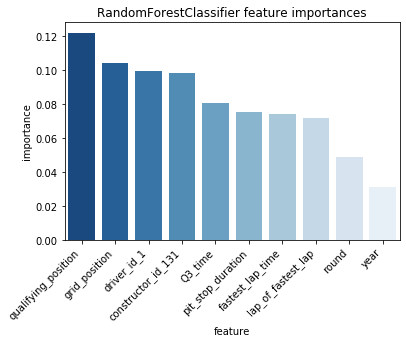

In [27]:
bplot = sns.barplot(x = 'feature', y = 'importance', data = df_features.head(10),
            palette = 'Blues_r')

bplot.set_xticklabels(bplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('RandomForestClassifier feature importances')
plt.show()

Analysis of feature importances:
* Driving for the Mercedes team has a very high importance which could be considered to be problematic, because for the enjoyability and fairness of the sport, it's detrimental if one team outperforms others heavily. Simply being from the Mercedes team already increases your win chances (predictions) highly.
* It's interesting that many circuits have almost no effect on who wins. This should be considered as a positive thing, because this means that the circuits are fair for different teams (and drivers).
* It's interesting that being Lewis Hamilton has such a high effect on whether the driver is predicted as being a race winner. This is neither good or bad, but rather noteworthy how dominating his performances have been.

## Analysis of the 2012 season

Getting all the race results in the year 2012.

In [28]:
# Getting all of the id-s of the races in the year 2012
races_2012 = races[races['year'] == 2012]
race_ids_2012 = races_2012['race_id'].tolist()
# Getting all the race results based on found race id-s
results_2012 = results.loc[results['race_id'].isin(race_ids_2012)]
# Getting all the drivers of that season (id-s and names as list)
driver_ids_2012 = results_2012.driver_id.unique().tolist()
driver_names_2012 = []
forenames = drivers.loc[drivers['driver_id'].isin(driver_ids_2012)]['forename'].tolist()
surnames = drivers.loc[drivers['driver_id'].isin(driver_ids_2012)]['surname'].tolist()
temp_ids = drivers.loc[drivers['driver_id'].isin(driver_ids_2012)]['driver_id'].tolist()
driver_ids_2012 = temp_ids
for i in range(len(surnames)):
    driver_names_2012.append(forenames[i] + " " + surnames[i])
# Finding all the constructors of that year (id-s and names)
constructor_ids_2012 = results_2012.constructor_id.unique()
constructor_names_2012 = constructors.loc[constructors['constructor_id'].isin(constructor_ids_2012)]['name'].tolist()
# Filtering the driver_standings dataframe to contain only data of season 2012
driver_standings_2012 = driver_standings[driver_standings['race_id'].isin(race_ids_2012)]
# Filtering the constructor_standings dataframe to contain only data of season 2012
constructor_standings_2012 = constructor_standings[constructor_standings['race_id'].isin(race_ids_2012)]
# Filtering the constructor_results dataframe to contain only data of season 2012
constructor_results_2012 = constructor_results[constructor_results['race_id'].isin(race_ids_2012)]
# Filtering the qualifying dataframe to contain only data of season 2012
qualifying_2012 = qualifying[qualifying['race_id'].isin(race_ids_2012)]
# Filtering the lap_times dataframe to contain only data of season 2012
lap_times_2012 = lap_times[lap_times['race_id'].isin(race_ids_2012)]
# Filtering the pit_stops dataframe to contain only data of season 2012 
pit_stops_2012 = pit_stops[pit_stops['race_id'].isin(race_ids_2012)]

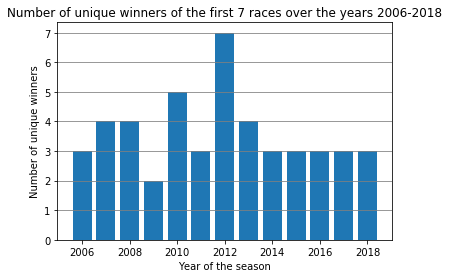

In [29]:
# Finding the number of unique winners of the first 7 races of the season in 2006 to 2018
# (7 seasons before and 7 seasons after year 2012)
years_to_find_7 = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
nr_of_unique_winners = []
for year in years_to_find_7:
    races_that_year = races[races['year'] == year]
    race_ids_that_year = races_that_year['race_id'].tolist()
    winners_first_7_races = results[results['race_id'].isin(race_ids_that_year[0:7])]
    winners_first_7_races = winners_first_7_races[winners_first_7_races['position'] == '1']['driver_id'].tolist()
    nr_of_unique = np.array(winners_first_7_races)
    nr_of_unique = np.unique(nr_of_unique)
    nr_of_unique_winners.append(len(nr_of_unique))

plt.bar(years_to_find_7, nr_of_unique_winners, width=0.8, bottom=None, align='center', data=None)
plt.ylabel('Number of unique winners')
plt.xlabel('Year of the season') 
plt.title("Number of unique winners of the first 7 races over the years 2006-2018")
plt.grid(color='grey', which='major', axis='y', linestyle='solid') # For the horizontal lines (not perfect, should be behind the plots)
plt.show()

C:\Users\Siim\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


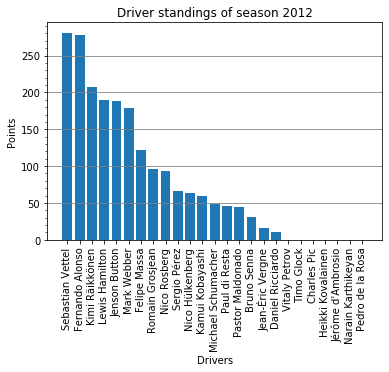

In [30]:
# Finding the final results of the 2012 season 
last_race_of_2012 = race_ids_2012[len(race_ids_2012)-1]
driver_standings_2012_last = driver_standings[driver_standings['race_id'] == last_race_of_2012]
driver_standings_2012_last = driver_standings_2012_last[['driver_id','points','position']]
names = []
for i, row in driver_standings_2012_last.iterrows():
    index = driver_ids_2012.index(int(row['driver_id']))
    names.append(driver_names_2012[index]) 
driver_standings_2012_last['driver_name'] = names
driver_standings_2012_last = driver_standings_2012_last.sort_values(['position'], ascending=True)

plt.bar(driver_standings_2012_last['driver_name'], driver_standings_2012_last['points'], width=0.8, bottom=None, align='center', data=None)
plt.ylabel('Points')
plt.xlabel('Drivers') 
plt.title("Driver standings of season 2012")
plt.grid(color='grey', which='major', axis='y', linestyle='solid') # For the horizontal lines (not perfect, should be behind the plots)
plt.xticks(rotation='vertical')
plt.grid(color='grey', which='major', axis='y', linestyle='solid')
ml = MultipleLocator(10)
plt.axes().yaxis.set_minor_locator(ml)
plt.show()

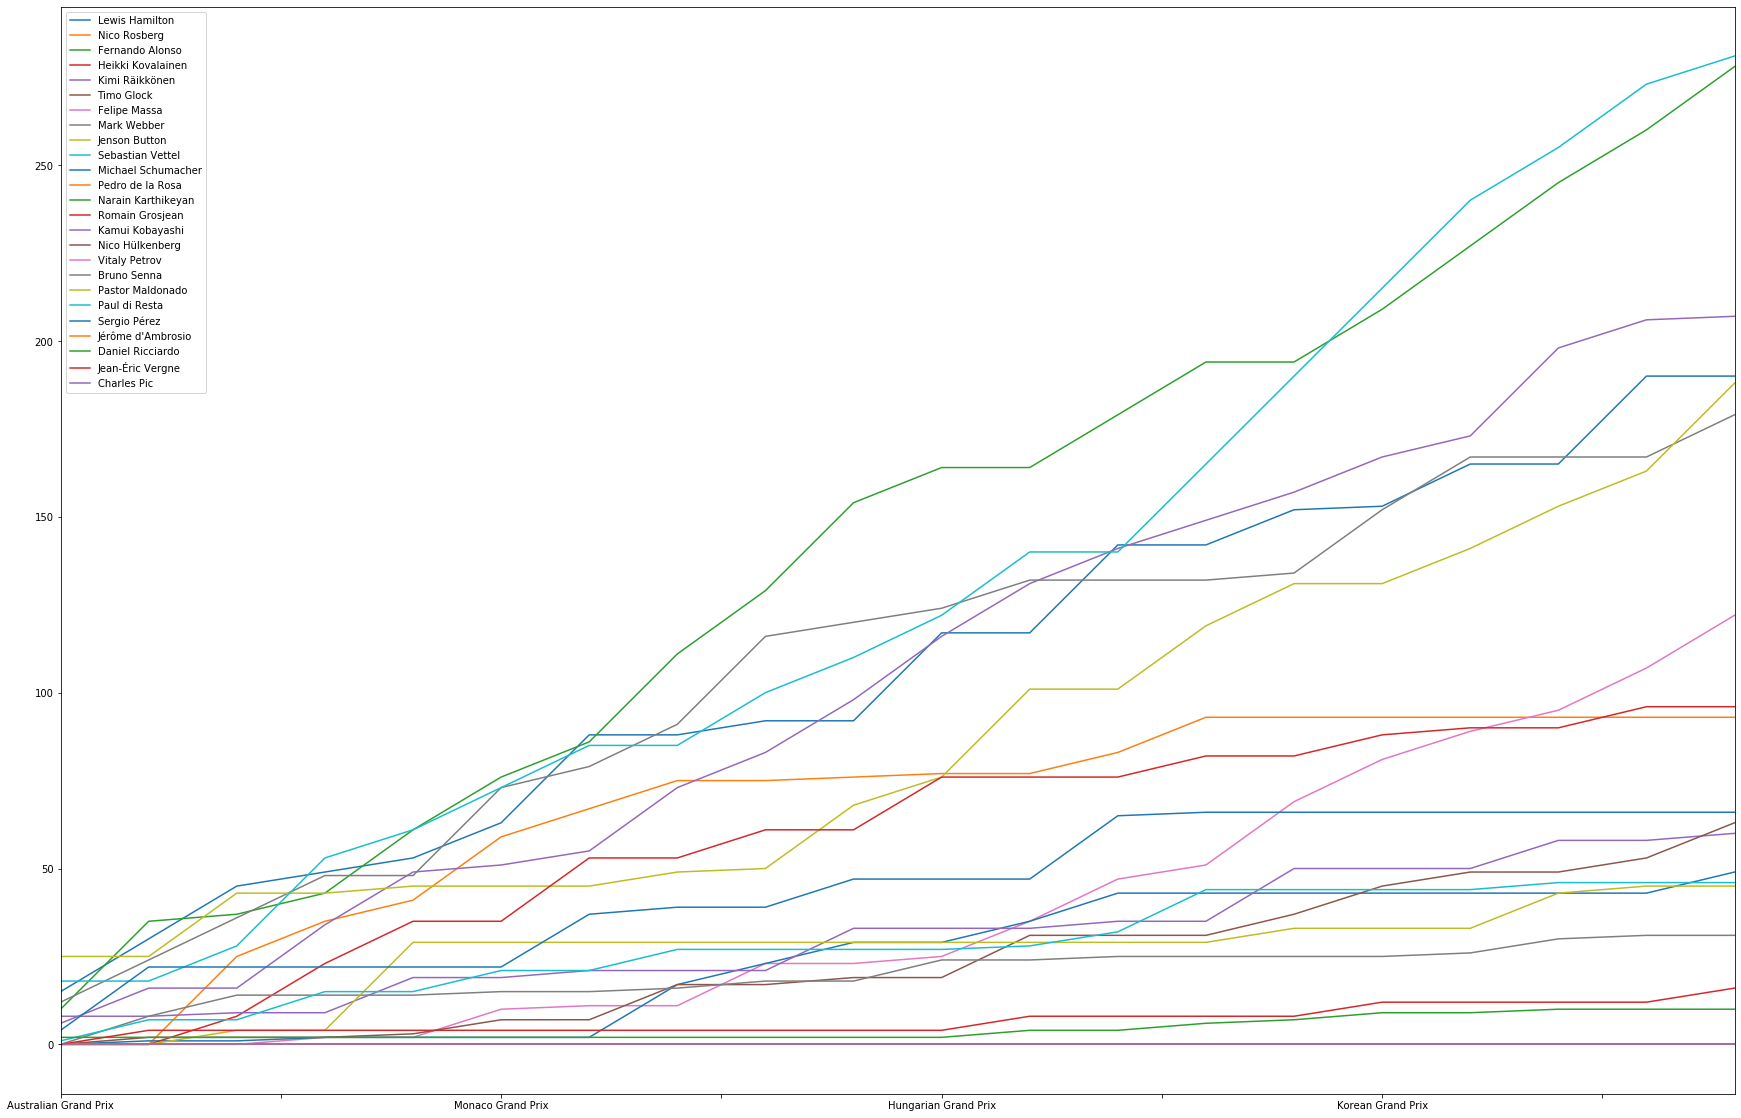

In [31]:
# Graph of points per race
race_names_2012 = races_2012['name'].tolist()

driver_standings_per_race_2012 = pd.DataFrame(columns = driver_names_2012, index = race_names_2012)

for idx, data in driver_standings_2012.iterrows():
    
    driver_forename = drivers.loc[drivers['driver_id'] == data['driver_id']]['forename'].item()
    driver_surname = drivers.loc[drivers['driver_id'] == data['driver_id']]['surname'].item()
    driver_name = driver_forename + " " + driver_surname
    current_race_name = races_2012.loc[races['race_id'] == data['race_id']]['name'].item()
    current_driver_points = data['points']
    
    driver_standings_per_race_2012.at[current_race_name, driver_name] = current_driver_points
    
driver_standings_per_race_2012 = driver_standings_per_race_2012.fillna(0)
ax = driver_standings_per_race_2012.plot(figsize = (30, 20))

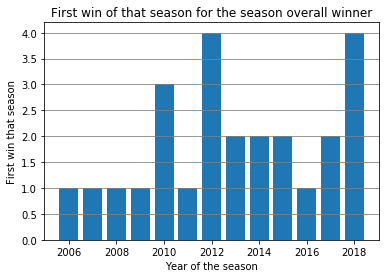

In [32]:
# Finding when did the winner of a season win for the first time in that season (2006-2018)
years_to_find_winner = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
first_wins = []
for year in years_to_find_winner:
    races_that_year = races[races['year'] == year]
    race_ids_that_year = races_that_year['race_id'].tolist()
    last_race_of_the_year = race_ids_that_year[len(race_ids_that_year)-1]
    driver_standings_that_year_last = driver_standings[driver_standings['race_id'] == last_race_of_the_year]
    winner = driver_standings_that_year_last[driver_standings_that_year_last['position_text']=='1']['driver_id'].item()
    first_win = 0
    
    for i in range(len(race_ids_that_year)):
        results_that_race = results[results['race_id'] == race_ids_that_year[i]]
        winner_of_that_race = results_that_race[results_that_race['position_text'] == '1']['driver_id'].item()
        if(winner_of_that_race == winner):
            first_win = i+1
            break
    first_wins.append(first_win)
plt.bar(years_to_find_winner, first_wins, width=0.8, bottom=None, align='center', data=None)
plt.ylabel('First win that season')
plt.xlabel('Year of the season') 
plt.title("First win of that season for the season overall winner")
plt.grid(color='grey', which='major', axis='y', linestyle='solid') # For the horizontal lines (not perfect, should be behind the plots)
plt.show()